In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


In [2]:
import ReactiveMP.messageout

In [3]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [4]:
function Φ(y, u, h)
    na = length(y)
    nb = length(u)-1
    ne = length(h)-1
    ϕ([y; u; h[2:end]], Dict("na"=>na, "nb"=>nb, "ne"=>ne, "nd"=>2, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false))
end

Φ (generic function with 1 method)

In [5]:
data_seed, params_seed = 42, 420

(42, 420)

In [6]:
include("../helpers/nonlinear_node.jl")

In [35]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order, nsamples, seed)
    obs_prec = 1e12  # softening plus
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), obs_prec*diageye(h_order)))}
    w  = randomvar()
    h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
    z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
    AR_meta_1 = ARMeta(Multivariate, h_order, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order), diageye(h_order))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(zeros(h_order), diageye(h_order))), meta = NonlinearMeta(Φ, nsamples, y_prev[t], u[t], seed)}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(dot(ẑ[t], b) + dot(h[t], c), obs_prec)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

narmax (generic function with 2 methods)

In [36]:
ReactiveMP.approximate_prod_with_sample_list(SampleList(randn(100), NormalMeanVariance(0.0, 1.0)), 100)

LoadError: MethodError: no method matching iterate(::NormalMeanVariance{Float64})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [37]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10, nsamples=100, seed=10)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, h_order, full_order, nsamples, seed,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
#     fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginals!(z, MvNormalMeanPrecision(randn(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(randn(h_order), diageye(h_order)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [38]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [39]:
# Read data from CSV file
df = DataFrame(CSV.File("../datasets/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [40]:
# normalization
input = (input .- mean(input))/std(input)
output = (output .- mean(output))/std(output)

131072-element Vector{Float64}:
  0.16079923510341107
  0.22775112557812904
  0.18754101784311708
  0.06100846540391118
 -0.08957707645721216
 -0.18838039383721755
 -0.19097550097668597
 -0.10483293373486675
  0.02295126604669645
  0.13305126280854654
  0.17798502765446092
  0.1377374454481209
  0.032407948886333235
  ⋮
 -0.32807023315970646
 -0.3752131180904102
 -0.2764304116696352
 -0.08649480119047896
  0.12356085294471451
  0.28107729827796324
  0.31041980932783675
  0.217070901249631
  0.08335261893326895
 -0.03750817227043455
 -0.1286873084587455
 -0.1506604647219554

In [41]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

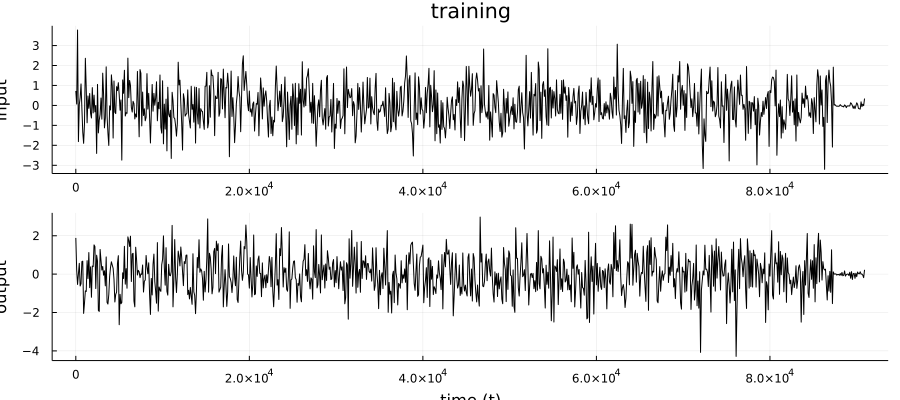

In [42]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

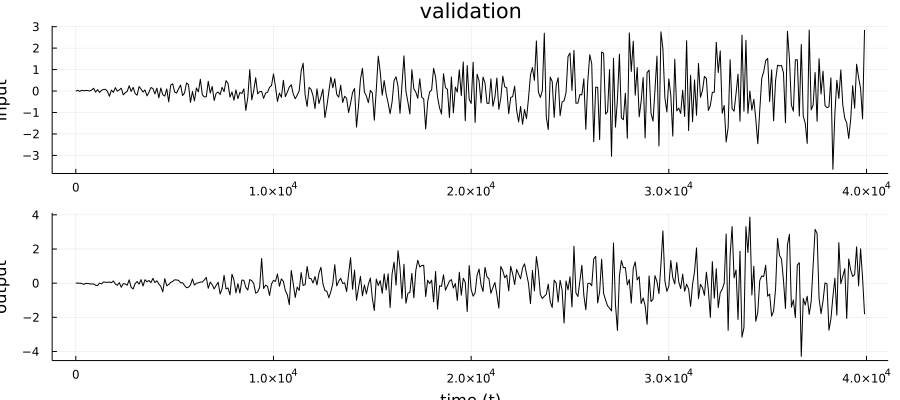

In [43]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [44]:
order_y, order_u, order_h = 2, 2, (2+1)
full_order = 24

24

In [45]:
# train_size = 800
# test_size = 1000
train_size = 100
test_size = 50

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [46]:
# @unpack fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = load("../dump/narmax_inference_result.jld2")

In [47]:
include("../helpers/ar_extension.jl")

In [48]:
coefs_mean = zeros(full_order); 
coefs_precision = diageye(full_order)

fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(zeros(order_h), diageye(order_h)),
                                                       w_prior=(1e4, 1.0), 
                                                       η_prior=(zeros(full_order), diageye(full_order)),
                                                       τ_prior=(1.0, 1.0), vmp_its=10, seed=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


In [255]:
# jldsave("../dump/narmax_inference_result.jld2", h_)

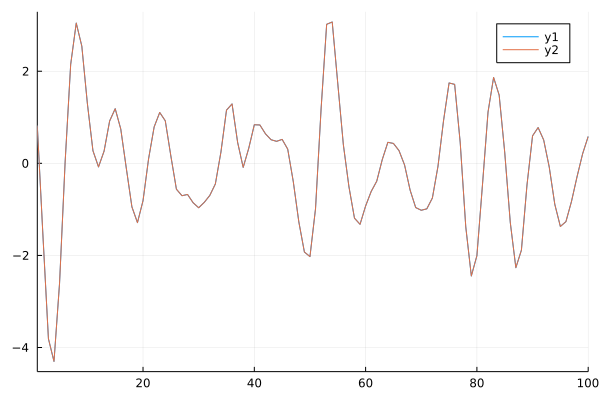

In [49]:
mfrom, mto = 1, 100
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [50]:
mean(w_)

10023.708847761991

In [51]:
mean(τ_)

2.302952585837516

In [52]:
mean(η_)

24-element Vector{Float64}:
  0.5651816926459475
  0.046537313325077954
 -0.17450368222684118
 -0.08459252047721239
  0.07937420481728949
  0.02590337726558762
 -0.0014021742146398941
  0.005538763594058723
 -0.009606002221382711
  0.06766752873151824
 -0.06027193482017727
  0.029764008003936738
 -0.021782298849987183
  0.006791197573383903
  0.14170492630729375
 -0.05724712884893603
 -0.0004932231257757569
 -0.02642602393511096
 -0.021235219930086903
  0.0019813318455874146
  0.012447023417593324
  0.07113900545318365
 -0.00439642630023199
  0.03353656424271858

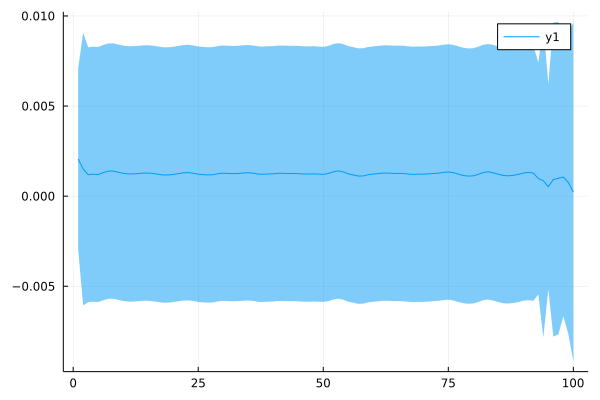

In [53]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## Prediction

In [54]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [55]:
function prediction(h_prior, w_mle, η_posterior, τ_posterior, y_prev, u; full_order, h_order, nsamples=100)
    h_out = @call_rule MvNormalMeanCovariance(:out, Marginalisation) (m_μ=MvNormalMeanPrecision(mean(h_[end]), precision(h_[end])), q_Σ=PointMass(transition(mean(w_), order_h)))
    ϕ_out = @call_rule NonlinearNode(:out, Marginalisation) (m_in=h_out, meta=NonlinearMeta(Φ, nsamples, y_prev, u, 42))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=ϕ_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, full_order, ARsafe()))
    c = zeros(full_order); c[1] = 1.0
    dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    c = zeros(h_order); c[1] = 1.0
    c_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(c), m_in2=h_out, meta=ReactiveMP.TinyCorrection())
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=dot_out, m_in2=c_out)
end

prediction (generic function with 1 method)

In [59]:
predictions = []
h_prior = h_[end]
w_prior = w_
τ_prior = τ_
for i in 1:length(Y_test)
    pred = prediction(h_prior, mean(w_), η_, τ_, X_test[i], U_test[i], full_order=full_order, h_order=order_h, nsamples=1000)
    push!(predictions, pred)
    fe_, h_post, θ_post, w_post, η_post, τ_post, _, _ = narmax_inference([Y_test[i]], [X_test[i]], [U_test[i]], h_order=order_h, full_order=full_order,
                                                                         h_prior=(mean(h_prior), precision(h_prior)),
                                                                         w_prior=(shape(w_prior), rate(w_prior)), 
                                                                         η_prior=(mean(η_), precision(η_)),
                                                                         τ_prior=(shape(τ_prior), rate(τ_prior)), vmp_its=10, seed=10);
    h_prior = h_post[end]
    τ_prior = τ_post
    w_prior = w_post
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

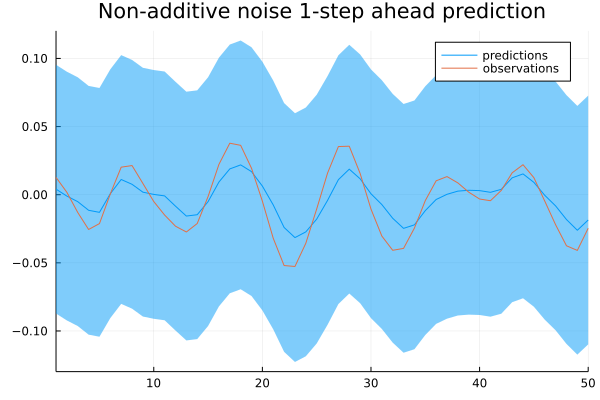

In [60]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions)))/10, label="predictions")
plot!(Y_test, xlims=(1, 50), title="Non-additive noise 1-step ahead prediction", label="observations")